<a href="https://colab.research.google.com/github/MariusMC8/Thesis-coding/blob/main/Risk_ranking_maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install geopandas matplotlib

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [3]:
url = "https://geodata.ucdavis.edu/gadm/gadm4.1/json/gadm41_ESP_1.json"
regions = gpd.read_file(url)

# Climate indicator: Hot Days above 35C (Climate-ADAPT)

In [4]:
from google.colab import files
uploaded = files.upload()

Saving Template storage data to analyse.csv to Template storage data to analyse.csv


In [5]:
import os

old_name = "Template storage data to analyse.csv"
new_name = "Hot_days_35C.csv"

os.rename(old_name, new_name)

In [6]:
data = pd.read_csv("Hot_days_35C.csv", sep=';', decimal=",", encoding='latin1')
data.head()

,ï»¿ID,Coordinates,Storage type,Region,Status,Power (MW),Capacity (MWh),Duration (hours),Importance score
0,Malpica Wind plus hybrid storage,"43.320000 , -8.810000",Battery,Galicia,Announced,7.75,15.5,2.00,2
1,BESS Sanxenxo,"42.400000 , -8.810000",Battery,Galicia,Announced,5.00,20.0,4.00,2
2,Santiago-Jares,"42.390000 , -7.090000",Battery,Galicia,Operational,5.00,5.0,1.00,2
3,Conso,"42.250000 , -7.160000",PHS,Galicia,Operational,270.00,2280.0,8.44,3
4,Soutelo PSP,"42.150000 , -7.190000",PHS,Galicia,Operational,215.00,NaN,NaN,3


In [56]:
#Fix Storage ID name
data.columns = data.columns.str.replace('ï»¿', 'Storage')

#Identify region names
data.columns = data.columns.str.strip()
data["Region"].unique()

array(['Galicia', 'PrincipadodeAsturias', 'Cantabria', 'PaísVasco',
       'ComunidadForaldeNavarra', 'Aragón', 'Cataluña', 'IslasBaleares',
       'ComunidadValenciana', 'RegióndeMurcia', 'Andalucía',
       'CastillayLeón', 'CeutayMelilla', 'IslasCanarias', 'Extremadura',
       'Castilla-LaMancha'], dtype=object)

In [57]:
#Fix region names
region_fix = {
    "PaÃ\xadsVasco": "PaísVasco",
    "AragÃ³n": "Aragón",
    "CataluÃ±a": "Cataluña",
    "RegiÃ³ndeMurcia": "RegióndeMurcia",
    "AndalucÃ\xada": "Andalucía",
    "CastillayLeÃ³n": "CastillayLeón"}

data["Region"] = data["Region"].replace(region_fix)

data["Region"].unique()

array(['Galicia', 'PrincipadodeAsturias', 'Cantabria', 'PaísVasco',
       'ComunidadForaldeNavarra', 'Aragón', 'Cataluña', 'IslasBaleares',
       'ComunidadValenciana', 'RegióndeMurcia', 'Andalucía',
       'CastillayLeón', 'CeutayMelilla', 'IslasCanarias', 'Extremadura',
       'Castilla-LaMancha'], dtype=object)

In [58]:
# Remove BOM, whitespace, invisible characters
data['Storage type'] = (
    data['Storage type']
    .astype(str)
    .str.encode('utf-8', 'ignore')
    .str.decode('utf-8')
    .str.replace('\u200b', '', regex=False)  # zero-width space
    .str.replace('\xa0', ' ', regex=False)   # non-breaking space
    .str.strip()
)

In [59]:
# Split coordinates into latitude and longitude
data[['lat','lon']] = data['Coordinates'].str.split(',', expand=True).astype(float)

In [60]:
# Convert coordinates to geodataframe
points = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data['lon'], data['lat']),
    crs="EPSG:4326"
)

In [61]:
#Hot days above 35°C 1991-2020 for each region
hot_days_35_present_dict = {
    "Galicia": 0.4,
    "PrincipadodeAsturias": 0.0,
    "Cantabria": 0.02,
    "PaísVasco": 0.16,
    "ComunidadForaldeNavarra": 3.59,
    "Aragón": 6.82,
    "Cataluña": 2.14,
    "ComunidadValenciana": 3.04,
    "RegióndeMurcia": 5.8,
    "Andalucía": 17.13,
    "Castilla-LaMancha": 14.12,
    "CastillayLeón": 1.94,
    "Extremadura": 21.32,
    "IslasCanarias": 0.02,
    "IslasBaleares": 0.11,
    "CeutayMelilla": 2.47,
}

# Clean column names by stripping whitespace
data.columns = data.columns.str.strip()

# Add a new column based on region
data["Hot days >35C 1991-2020"] = data["Region"].map(hot_days_35_present_dict)

In [62]:
#Define bins for hazard strength
bins = [-float("inf"), 1, 5, 15, 25, 35, float("inf")]
labels = [0, 1, 2, 3, 4, 5]

data['Hot days >35C 1991-2020 strength'] = pd.cut(
    data['Hot days >35C 1991-2020'].astype(float),
    bins=bins,
    labels=labels,
    right=False,
    include_lowest=True
).astype(int)

In [63]:
#Vulnerability score
vulnerability_hot_days_35 = {
    "Battery": 3,
    "PHS": 2,
    "Flywheel": 1
}

data["Vulnerability hot days >35C"] = data["Storage type"].map(vulnerability_hot_days_35)

In [64]:
#Increase in number of hot days above 35°C from 1991-2020 to 2011-2040 RCP4.5 for each region
hot_days_35_change45_dict = {
    "Galicia": 0.12,
    "PrincipadodeAsturias": 0.0,
    "Cantabria": 0.04,
    "PaísVasco": 0.23,
    "ComunidadForaldeNavarra": 1.55,
    "Aragón": 2.71,
    "Cataluña": 0.98,
    "ComunidadValenciana": 1.57,
    "RegióndeMurcia": 3.11,
    "Andalucía": 4.65,
    "Castilla-LaMancha": 5.65,
    "CastillayLeón": 1.61,
    "Extremadura": 5.95,
    "IslasCanarias": 0.0,
    "IslasBaleares": 0.13,
    "CeutayMelilla": 1.22,
}

# Clean column names by stripping whitespace
data.columns = data.columns.str.strip()

# Add a new column based on region
data["Hot days >35C change RCP4.5"] = data["Region"].map(hot_days_35_change45_dict)

In [65]:
#Define bins for future exposure score RCP4.5
bins = [-float("inf"), 1, 5, 15, 25, 35, float("inf")]
labels = [0, 1, 2, 3, 4, 5]

data["Hot days >35C future exposure score RCP4.5"] = pd.cut(
    data["Hot days >35C change RCP4.5"].astype(float),
    bins=bins,
    labels=labels,
    right=False,     # makes intervals: [0,1), [1,5), [5,15), ...
    include_lowest=True
).astype(int)

In [66]:
#Increase in number of hot days above 35°C from 1991-2020 to 2011-2040 RCP8.5 for each region
hot_days_35_change85_dict = {
    "Galicia": 0.11,
    "PrincipadodeAsturias": 0.0,
    "Cantabria": 0.04,
    "PaísVasco": 0.25,
    "ComunidadForaldeNavarra": 1.79,
    "Aragón": 3.20,
    "Cataluña": 1.10,
    "ComunidadValenciana": 1.95,
    "RegióndeMurcia": 3.78,
    "Andalucía": 6.63,
    "Castilla-LaMancha": 7.42,
    "CastillayLeón": 2.09,
    "Extremadura": 8.94,
    "IslasCanarias": 0.0,
    "IslasBaleares": 0.15,
    "CeutayMelilla": 1.29,
}

# Clean column names by stripping whitespace
data.columns = data.columns.str.strip()

# Add a new column based on region
data["Hot days >35C change RCP8.5"] = data["Region"].map(hot_days_35_change85_dict)

In [44]:
#Define bins for future exposure score RCP8.5
bins = [-float("inf"), 1, 5, 15, 25, 35, float("inf")]
labels = [0, 1, 2, 3, 4, 5]

data["Hot days >35C future exposure score RCP8.5"] = pd.cut(
    data["Hot days >35C change RCP8.5"].astype(float),
    bins=bins,
    labels=labels,
    right=False,     # makes intervals: [0,1), [1,5), [5,15), ...
    include_lowest=True
).astype(int)

In [19]:
#Future vulnerability score (vulnerability score x exposure score)
data['Future_vulnerability_score4.5'] = data["Vulnerability hot days >35C"] * data["Hot days >35C future exposure score RCP4.5"]
data['Future_vulnerability_score8.5'] = data["Vulnerability hot days >35C"] * data["Hot days >35C future exposure score RCP8.5"]

In [20]:
#Hot days above 35C 2011-2040 RCP4.5 for each region
hot_days_35_future45_dict = {
    "Galicia": 0.19,
    "PrincipadodeAsturias": 0.0,
    "Cantabria": 0.05,
    "PaísVasco": 0.38,
    "ComunidadForaldeNavarra": 4.83,
    "Aragón": 8.94,
    "Cataluña": 2.92,
    "ComunidadValenciana": 4.31,
    "RegióndeMurcia": 8.7,
    "Andalucía": 20.73,
    "Castilla-LaMancha": 18.91,
    "CastillayLeón": 3.58,
    "Extremadura": 26.69,
    "IslasCanarias": 0.0,
    "IslasBaleares": 0.26,
    "CeutayMelilla": 3.84,
}

# Clean column names by stripping whitespace
data.columns = data.columns.str.strip()

# Add a new column based on region
data["Hot days >35C 2011-2040 RCP4.5"] = data["Region"].map(hot_days_35_future45_dict)

In [45]:
#Define bins for future hazard strength RCP4.5
bins = [-float("inf"), 1, 5, 15, 25, 35, float("inf")]
labels = [0, 1, 2, 3, 4, 5]

data["Hot days >35C 2011-2040 hazard strength RCP4.5"] = pd.cut(
    data["Hot days >35C 2011-2040 RCP4.5"].astype(float),
    bins=bins,
    labels=labels,
    right=False,     # makes intervals: [0,1), [1,5), [5,15), ...
    include_lowest=True
).astype(int)

In [22]:
#Hot days above 35C 2011-2040 RCP8.5 for each region
hot_days_35_future85_dict = {
    "Galicia": 0.18,
    "PrincipadodeAsturias": 0.0,
    "Cantabria": 0.05,
    "PaísVasco": 0.43,
    "ComunidadForaldeNavarra": 5.15,
    "Aragón": 9.53,
    "Cataluña": 3.09,
    "ComunidadValenciana": 4.76,
    "RegióndeMurcia": 9.26,
    "Andalucía": 22.75,
    "Castilla-LaMancha": 20.78,
    "CastillayLeón": 4.13,
    "Extremadura": 29.83,
    "IslasCanarias": 0.0,
    "IslasBaleares": 0.29,
    "CeutayMelilla": 3.97,
}

# Clean column names by stripping whitespace
data.columns = data.columns.str.strip()

# Add a new column based on region
data["Hot days >35C 2011-2040 RCP8.5"] = data["Region"].map(hot_days_35_future85_dict)

In [46]:
#Define bins for future hazard strength RCP8.5
bins = [-float("inf"), 1, 5, 15, 25, 35, float("inf")]
labels = [0, 1, 2, 3, 4, 5]

data["Hot days >35C 2011-2040 hazard strength RCP8.5"] = pd.cut(
    data["Hot days >35C 2011-2040 RCP8.5"].astype(float),
    bins=bins,
    labels=labels,
    right=False,     # makes intervals: [0,1), [1,5), [5,15), ...
    include_lowest=True
).astype(int)

In [47]:
#Calculating present risk
data['risk_current'] = (
    data['Hot days >35C 1991-2020 strength'].astype(float) *
    data['Vulnerability hot days >35C'].astype(float) *
    data['Importance score'].astype(float) )
points = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data['lon'], data['lat']),
    crs="EPSG:4326"
)

#Calculating future risk RCP4.5
data['risk_future_RCP4.5'] = (
    data['Hot days >35C 2011-2040 hazard strength RCP4.5'].astype(float) *
    data['Future_vulnerability_score4.5'].astype(float) *
    data['Importance score'].astype(float) )
points = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data['lon'], data['lat']),
    crs="EPSG:4326"
)

#Calculating future risk RCP8.5
data['risk_future_RCP8.5'] = (
    data['Hot days >35C 2011-2040 hazard strength RCP8.5'].astype(float) *
    data['Future_vulnerability_score8.5'].astype(float) *
    data['Importance score'].astype(float) )
points = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data['lon'], data['lat']),
    crs="EPSG:4326"
)

#Calculating change in risk
data['risk_change4.5'] = (
    data['risk_future_RCP4.5'] - data['risk_current'] )

data['risk_change8.5'] = (
    data['risk_future_RCP8.5'] - data['risk_current'] )

In [48]:
#Normalise and create colour map for risk values
norm = mcolors.Normalize(vmin=data['risk_current'].min(), vmax=data['risk_current'].max())
cmap = cm.ScalarMappable(norm=norm, cmap='Reds')

In [49]:
# Ensure numeric columns
cols_to_numeric = [
    'Hot days >35C 1991-2020 strength',
    'Hot days >35C 2011-2040 hazard strength RCP4.5',
    'Hot days >35C 2011-2040 hazard strength RCP8.5',
    'Vulnerability hot days >35C',
    'Importance score',
    'Hot days >35C future exposure score RCP4.5',
    'Hot days >35C future exposure score RCP8.5',
    'Future_vulnerability_score4.5',
    'Future_vulnerability_score8.5',
    'risk_current',
    'risk_future_RCP4.5',
    'risk_future_RCP8.5',
    'risk_change4.5',
    'risk_change8.5'
]
for col in cols_to_numeric:
    data[col] = pd.to_numeric(data[col], errors='coerce')

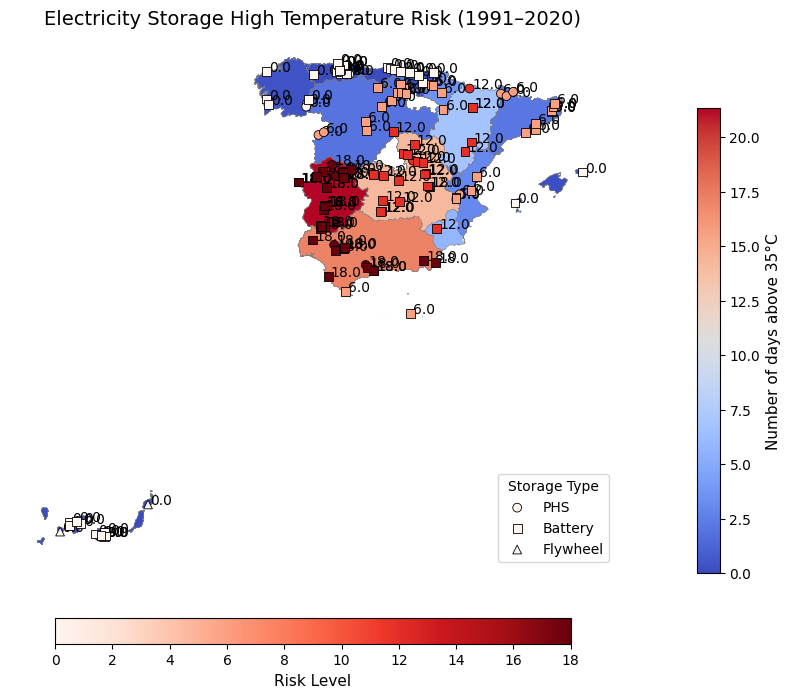

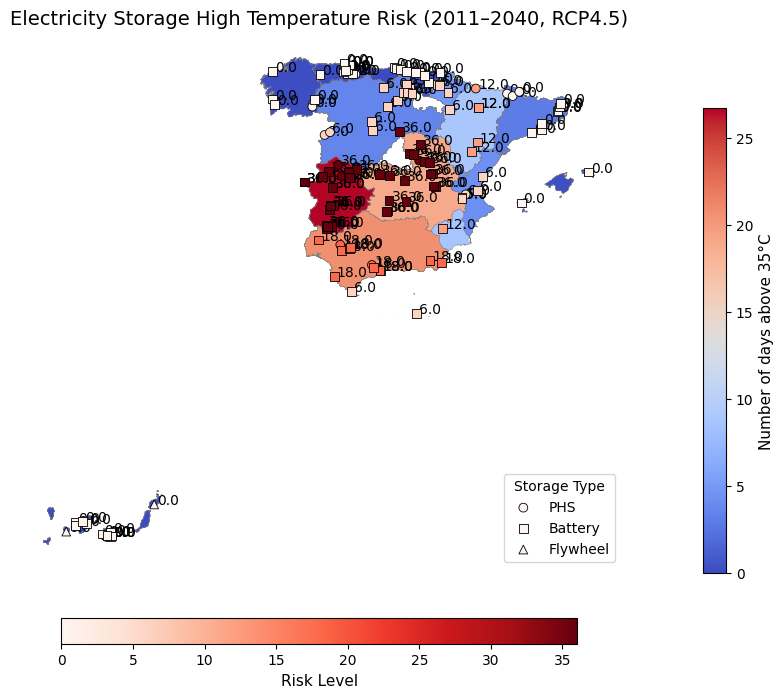

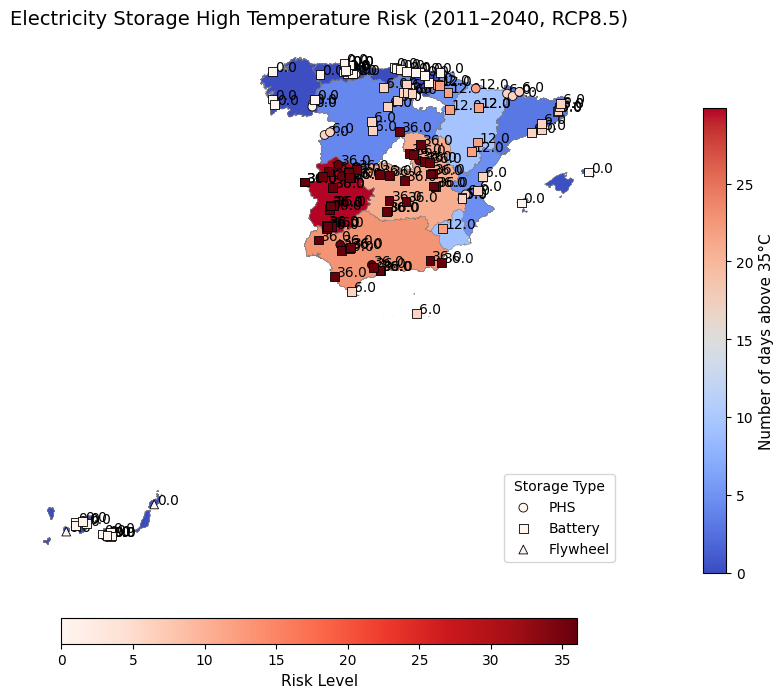

In [ ]:
# Function for plotting 1
def plot_map(temp_col, risk_col, title, temp_change=False):
  fig, ax = plt.subplots(figsize=(10, 8))

  # Merge temperature data with regions for plotting background
  merged_regions_temp = regions.merge(data[['Region', temp_col]], left_on="NAME_1", right_on="Region", how="left")

  # Background = regional mean temperature
  merged_regions_temp.plot(column=temp_col, cmap="coolwarm", legend=False, ax=ax, edgecolor='grey', linewidth=0.3)

# --- BEFORE the overlay, compute shared norm for the risk_col ---
# use points[risk_col] (ensure it's numeric)
  vals = points[risk_col].to_numpy(dtype=float)
# decide vmin/vmax. For change maps we want symmetric range around 0:
  if temp_change:
    abs_max = max(abs(vals.min()), abs(vals.max()))
    vmin, vmax = -abs_max, abs_max
    norm_risk = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
    cmap_risk = 'RdBu_r'
  else:
    vmin, vmax = vals.min(), vals.max()
    norm_risk = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap_risk = 'Reds'


  #Overlay storage facilities
  markers = {'PHS': 'o', 'Battery': 's', 'Flywheel': '^'}
  # plotting order: put larger markers first if you want them behind
  for t, marker in markers.items():
    subset = points[points['Storage type'] == t].copy()
    if subset.empty:
       continue
    xs = subset.geometry.x.values
    ys = subset.geometry.y.values
    cs = subset[risk_col].astype(float).values  # colour values

    sc = ax.scatter(
        xs, ys,
        c=cs,
        cmap=cmap_risk,
        norm=norm_risk,
        marker=marker,
        s=40,               # control marker size here
        edgecolor='black',
        linewidth=0.6,
        label=t,
        zorder=5
    )
# keep reference to the ScalarMappable for the colorbar
  sm_for_colorbar = sc

    # Add text labels to the points
  for i, row in points.iterrows():
      # Check if the risk value is not NaN before adding text
      if pd.notna(row[risk_col]):
          ax.text(row.geometry.x + 0.1, row.geometry.y, f"{row[risk_col]:.1f}", fontsize=10)

  #Add colour bar for temperature (right side)
  sm_temp = cm.ScalarMappable(
        norm=plt.Normalize(
            vmin=merged_regions_temp[temp_col].min(),
            vmax=merged_regions_temp[temp_col].max()
        ),
        cmap='coolwarm'
    )
  cbar_temp = fig.colorbar(sm_temp, ax=ax, fraction=0.03, pad=0.02, shrink=0.8)
  cbar_temp.set_label('Number of days above 35°C', fontsize=11)

  #Add colour bar for risk values (bottom)
  sm_risk = cm.ScalarMappable(norm=norm_risk, cmap=cmap_risk)
  sm_risk.set_array([])   # necessary in some Matplotlib versions
  cbar_risk = fig.colorbar(sm_risk, ax=ax, orientation='horizontal',
                         fraction=0.05, pad=0.08, shrink=0.7)
  cbar_risk.set_label('Change in Risk Level' if temp_change else 'Risk Level', fontsize=11)

  plt.legend(title="Storage Type", loc='lower right')
  plt.title(title, fontsize=14)
  plt.axis('off')
  plt.show()

# Update the points GeoDataFrame to include the calculated risk columns
points = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data['lon'], data['lat']),
    crs="EPSG:4326"
)

#Map 1: Current risk
plot_map( temp_col='Hot days >35C 1991-2020',
         risk_col='risk_current',
          title='Electricity Storage High Temperature Risk (1991–2020)' )

#Map 2: Future risk RCP4.5
plot_map( temp_col='Hot days >35C 2011-2040 RCP4.5',
         risk_col='risk_future_RCP4.5',
          title='Electricity Storage High Temperature Risk (2011–2040, RCP4.5)')

#Map 3: Future risk RCP8.5
plot_map( temp_col='Hot days >35C 2011-2040 RCP8.5',
         risk_col='risk_future_RCP8.5',
          title='Electricity Storage High Temperature Risk (2011–2040, RCP8.5)')

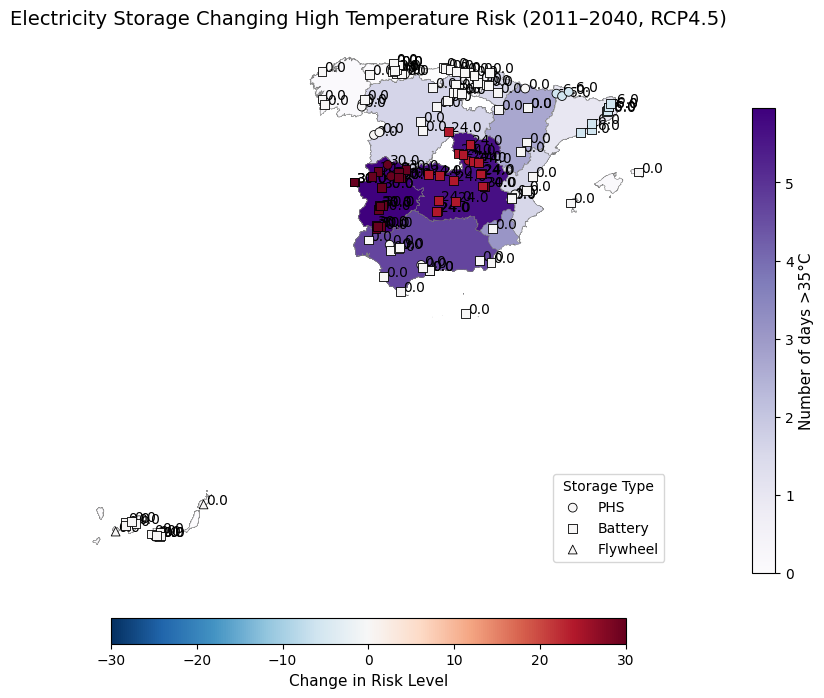

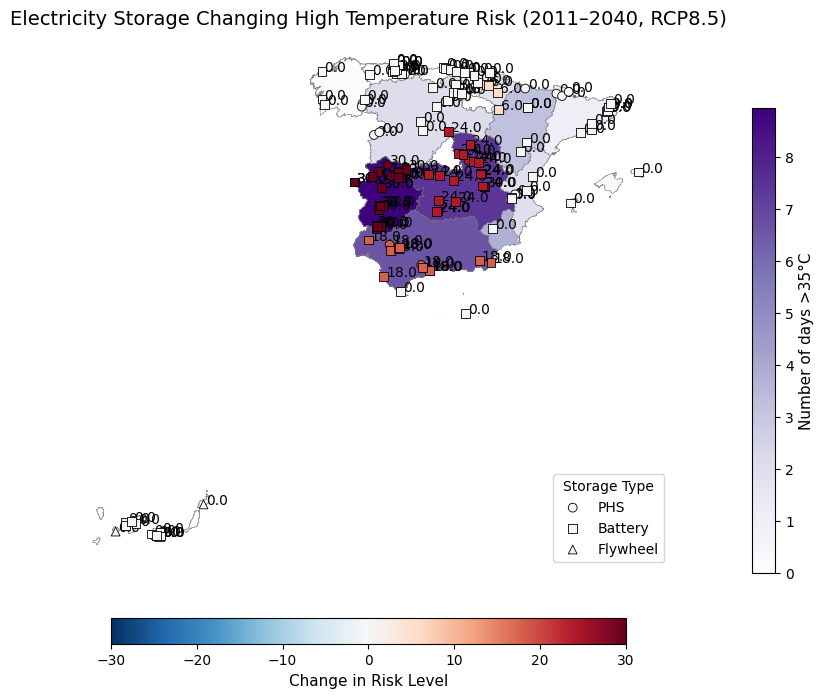

In [ ]:
# Function for plotting 2
def plot_map(temp_col, risk_col, title, temp_change=False):
  fig, ax = plt.subplots(figsize=(10, 8))

  # Merge temperature data with regions for plotting background
  merged_regions_temp = regions.merge(data[['Region', temp_col]], left_on="NAME_1", right_on="Region", how="left")

  # Determine colormap based on whether it's a temperature change map
  cmap_bg = "coolwarm" if not temp_change else "Purples"

  # Background = regional mean temperature
  merged_regions_temp.plot(column=temp_col, cmap=cmap_bg, legend=False, ax=ax, edgecolor='grey', linewidth=0.3)

  # --- BEFORE the overlay, compute shared norm for the risk_col ---
  # use points[risk_col] (ensure it's numeric)
  vals = points[risk_col].to_numpy(dtype=float)
  # decide vmin/vmax. For change maps we want symmetric range around 0:
  if temp_change:
    abs_max = max(abs(vals.min()), abs(vals.max()))
    vmin, vmax = -abs_max, abs_max
    norm_risk = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
    cmap_risk = 'RdBu_r'
  else:
    vmin, vmax = vals.min(), vals.max()
    norm_risk = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap_risk = 'Reds'

  if temp_change:
      # For risk change, ensure vmin and vmax are symmetric around 0 for the diverging colormap
      abs_max = max(abs(vmin), abs(vmax))
      norm_risk = mcolors.TwoSlopeNorm(vmin=-abs_max, vcenter=0, vmax=abs_max)
  else:
      norm_risk = mcolors.Normalize(vmin=vmin, vmax=vmax)


  #Overlay storage facilities
  markers = {'PHS': 'o', 'Battery': 's', 'Flywheel': '^'}
  # plotting order: put larger markers first if you want them behind
  for t, marker in markers.items():
    subset = points[points['Storage type'] == t].copy()
    if subset.empty:
       continue
    xs = subset.geometry.x.values
    ys = subset.geometry.y.values
    cs = subset[risk_col].astype(float).values  # colour values

    sc = ax.scatter(
        xs, ys,
        c=cs,
        cmap=cmap_risk,
        norm=norm_risk,
        marker=marker,
        s=40,               # control marker size here
        edgecolor='black',
        linewidth=0.6,
        label=t,
        zorder=5
    )
# keep reference to the ScalarMappable for the colorbar
  sm_for_colorbar = sc

 # Add text labels to the points
  for i, row in points.iterrows():
      # Check if the risk value is not NaN before adding text
      if pd.notna(row[risk_col]):
          ax.text(row.geometry.x + 0.1, row.geometry.y, f"{row[risk_col]:.1f}", fontsize=10)

  #Add colour bar for temperature (right side)
  sm_temp = cm.ScalarMappable(
        norm=plt.Normalize(
            vmin=merged_regions_temp[temp_col].min(),
            vmax=merged_regions_temp[temp_col].max()
        ),
        cmap=cmap_bg # Use the variable cmap_bg
    )
  cbar_temp = fig.colorbar(sm_temp, ax=ax, fraction=0.03, pad=0.02, shrink=0.8)
  cbar_temp.set_label('Number of days >35°C' if temp_change else 'Number of days >35°C', fontsize=11)

  #Add colour bar for risk values (bottom)
  sm_risk = cm.ScalarMappable(norm=norm_risk, cmap=cmap_risk)
  sm_risk.set_array([])   # necessary in some Matplotlib versions
  cbar_risk = fig.colorbar(sm_risk, ax=ax, orientation='horizontal',
                         fraction=0.05, pad=0.08, shrink=0.7)
  cbar_risk.set_label('Change in Risk Level' if temp_change else 'Risk Level', fontsize=11)

  plt.legend(title="Storage Type", loc='lower right')
  plt.title(title, fontsize=14)
  plt.axis('off')
  plt.show()

#Map 4: Future risk with temperature change background RCP4.5
plot_map(
    temp_col='Hot days >35C change RCP4.5',
    risk_col='risk_change4.5',
    title='Electricity Storage Changing High Temperature Risk (2011–2040, RCP4.5)',
    temp_change=True
)

#Map 5: Future risk with temperature change background RCP8.5
plot_map(
    temp_col='Hot days >35C change RCP8.5',
    risk_col='risk_change8.5',
    title='Electricity Storage Changing High Temperature Risk (2011–2040, RCP8.5)',
    temp_change=True
)

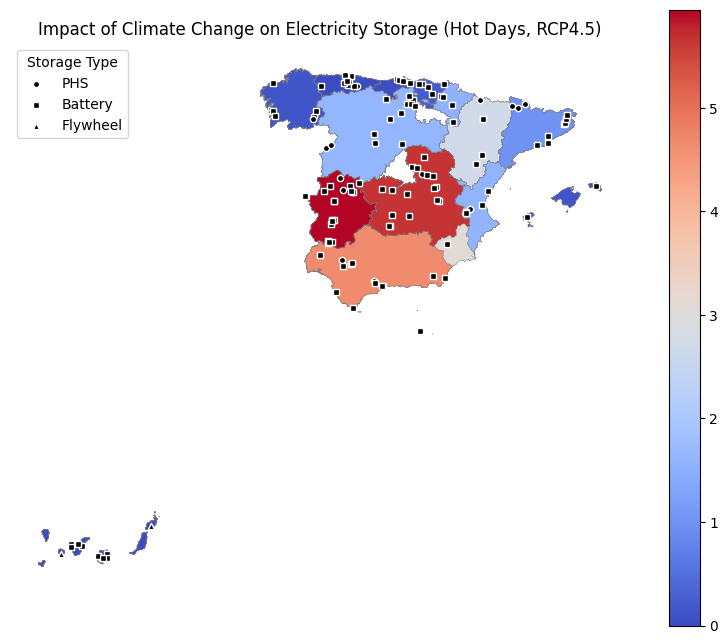

In [ ]:
#Function for plotting maps based on Hawchar et al (2020) step 5
def plot_climate_impact(temp_col, title):
    fig, ax = plt.subplots(figsize=(10, 8))

    # Background: climate values
    merged = regions.merge(
        data[['Region', temp_col]],
        left_on="NAME_1", right_on="Region", how="left"
    )
    merged.plot(
        column=temp_col,
        cmap='coolwarm',
        legend=True,
        ax=ax,
        edgecolor='grey',
        linewidth=0.3
    )

    # Overlay infrastructure points (no vulnerability/importance yet!)
    markers = {'PHS': 'o', 'Battery': 's', 'Flywheel': '^'}
    for t, marker in markers.items():
        subset = data[data['Storage type'] == t]
        if not subset.empty:
            ax.scatter(
                subset['lon'], subset['lat'],
                color='black',
                marker=marker,
                s=20,
                edgecolor='white',
                label=t
            )

    ax.set_title(title)
    plt.axis('off')
    plt.legend(title="Storage Type")
    plt.show()
    plt.close() # Close the figure to prevent it from overlapping with future plots

# Call the function outside its definition
plot_climate_impact(
    temp_col='Hot days >35C change RCP4.5',
    title='Impact of Climate Change on Electricity Storage (Hot Days, RCP4.5)'
)

/tmp/ipython-input-1318312593.py:64: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_bg = cm.get_cmap("coolwarm", len(categories))


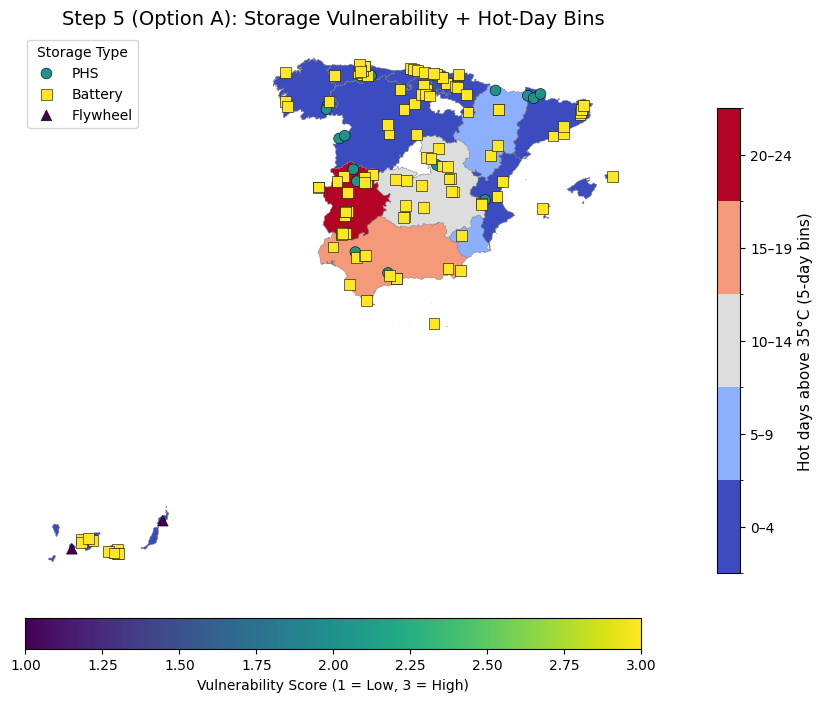

/tmp/ipython-input-1318312593.py:138: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_bg = cm.get_cmap("coolwarm", len(categories))


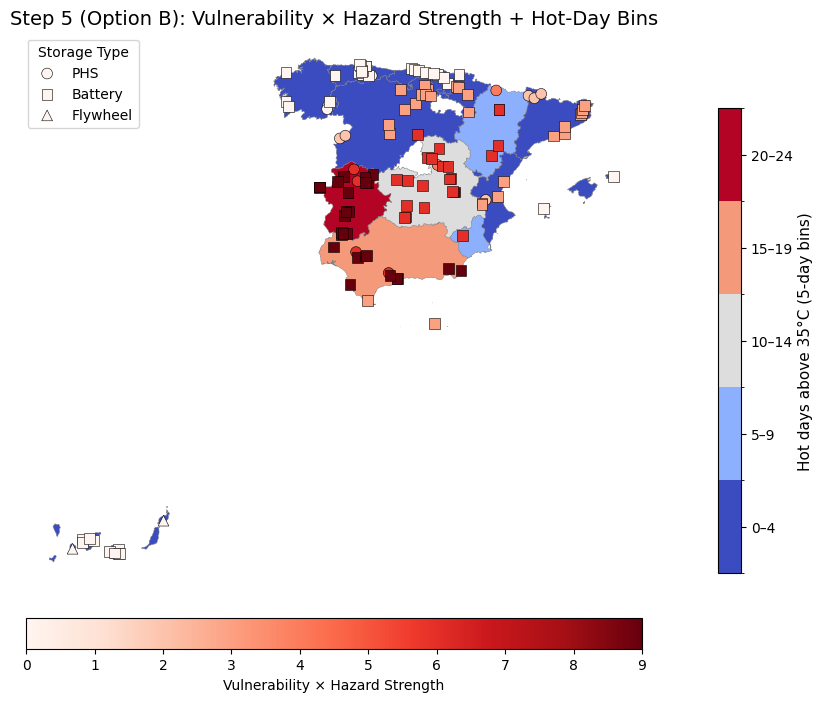

In [54]:
#TWO MORE OPTIONS FOR STEP 5
# =========================================================
# STEP 5 MAPS (Hawchar et al. 2020) WITH OPTIONS A & B
# =========================================================

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import numpy as np

# ---------------------------------------------------------
# CONFIG
# ---------------------------------------------------------
REGION_COL = "Region"
ASSET_TYPE_COL = "Storage type"
VULN_COL = "Vulnerability hot days >35C"
HAZARDCURRENT_COL = "Hot days >35C 1991-2020 strength"
HOTDAYSCURRENT_COL = "Hot days >35C 1991-2020"

# =========================================================
# 1. Create 5-day binned hot-day categories for regions
# =========================================================

def five_day_binning(df, col):
    df_col = df[[REGION_COL, col]].drop_duplicates(subset=[REGION_COL]).copy()
    vals = df_col[col]

    vmin, vmax = vals.min(), vals.max()
    if vmin == vmax:
        df[col + "_binned"] = str(int(vmin))
        return df

    start = (vmin // 5) * 5
    end = ((vmax + 4) // 5) * 5

    bins = list(range(int(start), int(end) + 5, 5))
    labels = [f"{bins[i]}–{bins[i+1]-1}" for i in range(len(bins)-1)]

    df[col + "_binned"] = pd.cut(df[col], bins=bins, labels=labels, right=False, include_lowest=True)
    return df

# Apply bins to current hot days
data = five_day_binning(data, HOTDAYSCURRENT_COL)


# =========================================================
# 2. OPTION A — Point colour = VULNERABILITY (1–3)
# =========================================================

def plot_step5_optionA(bg_col, title):
    fig, ax = plt.subplots(figsize=(10, 8))

    # Merge 5-day bins into regions
    merged = regions.merge(
        data[[REGION_COL, bg_col + "_binned"]].drop_duplicates(subset=[REGION_COL]),
        left_on="NAME_1", right_on=REGION_COL, how="left"
    )

    # Create legend categories
    categories = sorted(merged[bg_col + "_binned"].dropna().unique().tolist(),
                        key=lambda x: float(x.split("–")[0]))
    cmap_bg = cm.get_cmap("coolwarm", len(categories))
    bounds = np.arange(len(categories) + 1)
    norm_bg = mcolors.BoundaryNorm(bounds, cmap_bg.N)

    # Plot background
    merged.plot(
        column=bg_col + "_binned",
        cmap=cmap_bg,
        norm=norm_bg,
        ax=ax,
        edgecolor='grey',
        linewidth=0.3,
        legend=False
    )

    # Add custom background colorbar
    sm = cm.ScalarMappable(cmap=cmap_bg, norm=norm_bg)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, ticks=bounds[:-1] + 0.5, fraction=0.03, pad=0.02)
    cbar.set_ticklabels(categories)
    cbar.set_label("Hot days above 35°C (5-day bins)", fontsize=11)

    # Storage points coloured by vulnerability (1–3)
    markers = {'PHS': 'o', 'Battery': 's', 'Flywheel': '^'}
    vuln_norm = mcolors.Normalize(vmin=1, vmax=3)
    cmap_pts = "viridis"

    for t, marker in markers.items():
        subset = data[data[ASSET_TYPE_COL] == t]
        ax.scatter(
            subset['lon'], subset['lat'],
            c=subset[VULN_COL].astype(float),
            cmap=cmap_pts,
            norm=vuln_norm,
            marker=marker,
            s=60,
            edgecolor="black",
            linewidth=0.4,
            label=t
        )

    # Add point legend (storage type)
    plt.legend(title="Storage Type")

    # Add vulnerability colourbar
    sm_pts = cm.ScalarMappable(cmap=cmap_pts, norm=vuln_norm)
    plt.colorbar(sm_pts, ax=ax, orientation="horizontal", fraction=0.05, pad=0.05)\
        .set_label("Vulnerability Score (1 = Low, 3 = High)")

    plt.title(title, fontsize=14)
    plt.axis("off")
    plt.show()


# =========================================================
# 3. OPTION B — Point colour = Vulnerability × Hazard Strength (current)
# =========================================================

data["VulnHazard_current"] = (
    data[VULN_COL].astype(float) *
    data[HAZARDCURRENT_COL].astype(float)
)

def plot_step5_optionB(bg_col, title):
    fig, ax = plt.subplots(figsize=(10, 8))

    # Merge binned background
    merged = regions.merge(
        data[[REGION_COL, bg_col + "_binned"]].drop_duplicates(subset=[REGION_COL]),
        left_on="NAME_1", right_on=REGION_COL, how="left"
    )

    categories = sorted(merged[bg_col + "_binned"].dropna().unique().tolist(),
                        key=lambda x: float(x.split("–")[0]))
    cmap_bg = cm.get_cmap("coolwarm", len(categories))
    bounds = np.arange(len(categories) + 1)
    norm_bg = mcolors.BoundaryNorm(bounds, cmap_bg.N)

    merged.plot(
        column=bg_col + "_binned",
        cmap=cmap_bg,
        norm=norm_bg,
        ax=ax,
        edgecolor='grey',
        linewidth=0.3
    )

    sm = cm.ScalarMappable(cmap=cmap_bg, norm=norm_bg)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, ticks=bounds[:-1] + 0.5,
                        fraction=0.03, pad=0.02)
    cbar.set_ticklabels(categories)
    cbar.set_label("Hot days above 35°C (5-day bins)", fontsize=11)

    # Points: vulnerability × hazard current
    vals = data["VulnHazard_current"]
    norm_pts = mcolors.Normalize(vmin=vals.min(), vmax=vals.max())
    cmap_pts = "Reds"

    markers = {'PHS': 'o', 'Battery': 's', 'Flywheel': '^'}

    for t, marker in markers.items():
        subset = data[data[ASSET_TYPE_COL] == t]
        ax.scatter(
            subset["lon"], subset["lat"],
            c=subset["VulnHazard_current"].astype(float),
            cmap=cmap_pts,
            norm=norm_pts,
            marker=marker,
            s=60,
            edgecolor="black",
            linewidth=0.4,
            label=t
        )

    sm2 = cm.ScalarMappable(cmap=cmap_pts, norm=norm_pts)
    plt.colorbar(sm2, ax=ax, orientation="horizontal",
                 fraction=0.05, pad=0.05)\
        .set_label("Vulnerability × Hazard Strength")

    plt.title(title, fontsize=14)
    plt.legend(title="Storage Type")
    plt.axis("off")
    plt.show()


# =========================================================
# EXAMPLE CALLS
# =========================================================

# OPTION A
plot_step5_optionA(
    bg_col=HOTDAYSCURRENT_COL,
    title="Step 5 (Option A): Storage Vulnerability + Hot-Day Bins"
)

# OPTION B
plot_step5_optionB(
    bg_col=HOTDAYSCURRENT_COL,
    title="Step 5 (Option B): Vulnerability × Hazard Strength + Hot-Day Bins"
)


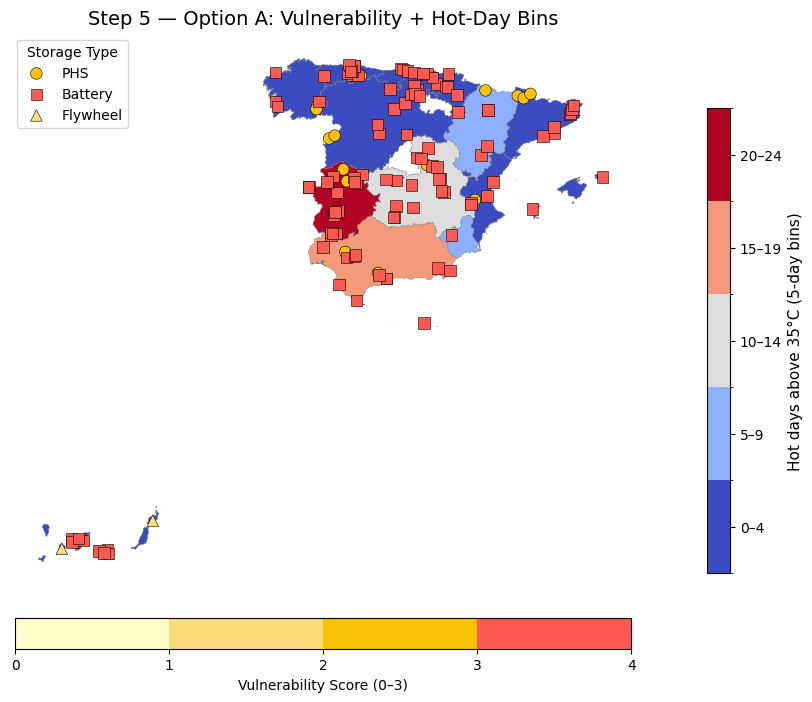

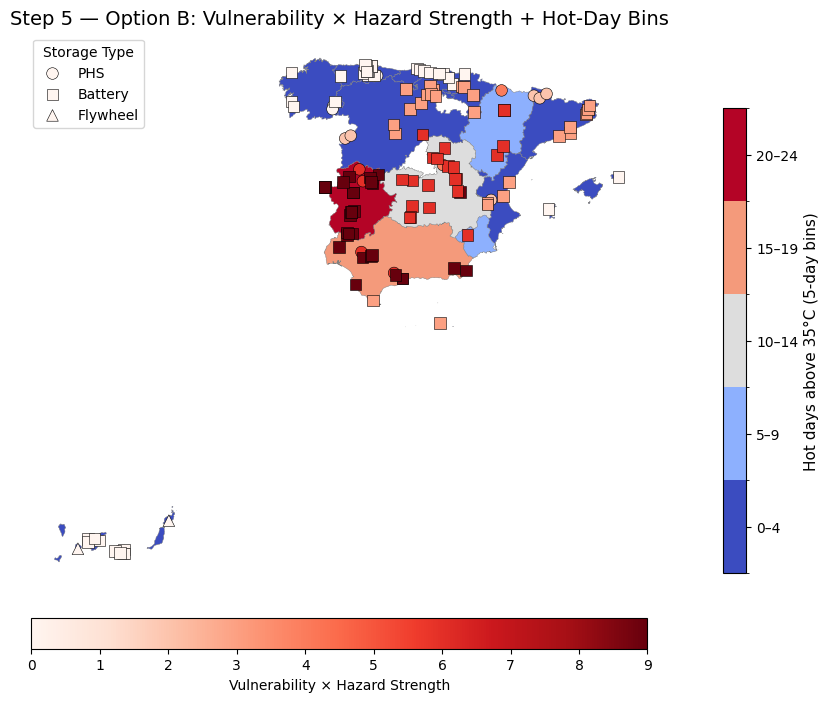

In [83]:
# =========================================================
# STEP 5 MAPS (Hawchar et al. 2020) — FIXED VERSION
# - Fixed deprecation warning
# - Strict 5-day bins
# - Discrete vulnerability colours
# =========================================================

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# ---------------------------------------------------------
# CONFIG
# ---------------------------------------------------------
REGION_COL = "Region"
ASSET_TYPE_COL = "Storage type"
VULN_COL = "Vulnerability hot days >35C"

HAZARDCURRENT_COL = "Hot days >35C 1991-2020 strength"
HOTDAYSCURRENT_COL = "Hot days >35C 1991-2020"


# =========================================================
# Create *strict* 5-day bins for hot-day counts in regions
# =========================================================

def apply_strict_5day_bins(df, col):
    df_copy = df.copy()
    vals = df_copy[col]

    vmin = 0                           # FORCE START AT 0
    vmax = max(vals.max(), 5)          # Ensure at least one bin

    # Build bins every 5 days
    bins = list(range(0, int((vmax//5)*5) + 10, 5))

    # Labels like 0–4, 5–9, 10–14, ...
    labels = [f"{bins[i]}–{bins[i+1]-1}" for i in range(len(bins)-1)]

    df_copy[col + "_binned"] = pd.cut(
        df_copy[col],
        bins=bins,
        labels=labels,
        include_lowest=True,
        right=False
    )
    return df_copy

data = apply_strict_5day_bins(data, HOTDAYSCURRENT_COL)


# =========================================================
# DISCRETE VULNERABILITY COLOURS (0,1,2,3)
# =========================================================

vuln_colors = ["#FFFFCB", "#FBDD7E", "#FAC205", "#FC5A50"]
vuln_cmap = mcolors.ListedColormap(vuln_colors)
vuln_norm = mcolors.BoundaryNorm([0,1,2,3,4], vuln_cmap.N)


# =========================================================
# OPTION A — Storage points coloured by vulnerability
# =========================================================

def plot_step5_optionA(bg_col, title):
    fig, ax = plt.subplots(figsize=(10, 8))

    # Merge binned region data
    merged = regions.merge(
        data[[REGION_COL, bg_col + "_binned"]].drop_duplicates(subset=[REGION_COL]),
        left_on="NAME_1", right_on=REGION_COL, how="left"
    )

    categories = sorted(
        merged[bg_col + "_binned"].dropna().unique().tolist(),
        key=lambda x: float(x.split("–")[0])
    )

    cmap_bg = plt.get_cmap("coolwarm", len(categories))   # FIXED
    bounds = np.arange(len(categories) + 1)
    norm_bg = mcolors.BoundaryNorm(bounds, cmap_bg.N)

    # Plot regions
    merged.plot(
        column=bg_col + "_binned",
        cmap=cmap_bg,
        norm=norm_bg,
        ax=ax,
        edgecolor="grey",
        linewidth=0.3,
        legend=False
    )

    # Background colourbar
    sm = plt.cm.ScalarMappable(cmap=cmap_bg, norm=norm_bg)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax,
                        ticks=bounds[:-1] + 0.5,
                        fraction=0.03, pad=0.02)
    cbar.set_ticklabels(categories)
    cbar.set_label("Hot days above 35°C (5-day bins)", fontsize=11)

    # ---- Vulnerability points ----
    markers = {'PHS': 'o', 'Battery': 's', 'Flywheel': '^'}

    for t, marker in markers.items():
        subset = data[data[ASSET_TYPE_COL] == t]

        ax.scatter(
            subset["lon"], subset["lat"],
            c=subset[VULN_COL].astype(float),
            cmap=vuln_cmap,
            norm=vuln_norm,
            marker=marker,
            s=70,
            edgecolor="black",
            linewidth=0.4,
            label=t
        )

    # Vulnerability colourbar
    sm_v = plt.cm.ScalarMappable(cmap=vuln_cmap, norm=vuln_norm)
    plt.colorbar(
        sm_v, ax=ax, orientation="horizontal",
        fraction=0.05, pad=0.05
    ).set_label("Vulnerability Score (0–3)")

    plt.title(title, fontsize=14)
    plt.legend(title="Storage Type")
    plt.axis("off")
    plt.show()


# =========================================================
# OPTION B — Points coloured by Vulnerability × Hazard
# =========================================================

data["VulnHazard_current"] = (
    data[VULN_COL].astype(float) *
    data[HAZARDCURRENT_COL].astype(float)
)

def plot_step5_optionB(bg_col, title):
    fig, ax = plt.subplots(figsize=(10, 8))

    # Merge region data
    merged = regions.merge(
        data[[REGION_COL, bg_col + "_binned"]].drop_duplicates(subset=[REGION_COL]),
        left_on="NAME_1", right_on=REGION_COL, how="left"
    )

    categories = sorted(
        merged[bg_col + "_binned"].dropna().unique().tolist(),
        key=lambda x: float(x.split("–")[0])
    )

    cmap_bg = plt.get_cmap("coolwarm", len(categories))     # FIXED
    bounds = np.arange(len(categories) + 1)
    norm_bg = mcolors.BoundaryNorm(bounds, cmap_bg.N)

    merged.plot(
        column=bg_col + "_binned",
        cmap=cmap_bg,
        norm=norm_bg,
        ax=ax,
        edgecolor="grey",
        linewidth=0.3
    )

    sm = plt.cm.ScalarMappable(cmap=cmap_bg, norm=norm_bg)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, ticks=bounds[:-1] + 0.5,
                        fraction=0.03, pad=0.02)
    cbar.set_ticklabels(categories)
    cbar.set_label("Hot days above 35°C (5-day bins)", fontsize=11)

    # Points = vulnerability × hazard
    vals = data["VulnHazard_current"]
    norm_pts = mcolors.Normalize(vmin=vals.min(), vmax=vals.max())

    markers = {'PHS': 'o', 'Battery': 's', 'Flywheel': '^'}

    for t, marker in markers.items():
        subset = data[data[ASSET_TYPE_COL] == t]

        ax.scatter(
            subset["lon"], subset["lat"],
            c=subset["VulnHazard_current"].astype(float),
            cmap="Reds",
            norm=norm_pts,
            marker=marker,
            s=70,
            edgecolor="black",
            linewidth=0.4,
            label=t
        )

    sm_pts = plt.cm.ScalarMappable(cmap="Reds", norm=norm_pts)
    plt.colorbar(
        sm_pts, ax=ax, orientation="horizontal",
        fraction=0.05, pad=0.05
    ).set_label("Vulnerability × Hazard Strength")

    plt.title(title, fontsize=14)
    plt.legend(title="Storage Type")
    plt.axis("off")
    plt.show()


# =========================================================
# EXAMPLE CALLS
# =========================================================

plot_step5_optionA(
    bg_col=HOTDAYSCURRENT_COL,
    title="Step 5 — Option A: Vulnerability + Hot-Day Bins"
)

plot_step5_optionB(
    bg_col=HOTDAYSCURRENT_COL,
    title="Step 5 — Option B: Vulnerability × Hazard Strength + Hot-Day Bins"
)


In [72]:
data.loc[data['Region']=="CastillayLeón",
         ['Storage type','Power (MW)', 'Capacity (MWh)',
          'Vulnerability hot days >35C', 'Hot days >35C 1991-2020 strength']]

,Storage type,Power (MW),Capacity (MWh),Vulnerability hot days >35C,Hot days >35C 1991-2020 strength
67,Battery,66.00,198.0,3,1
104,PHS,432.00,4285.0,2,1
105,PHS,858.00,8100.0,2,1
106,Battery,13.00,26.0,3,1
107,Battery,75.00,150.0,3,1
108,Battery,27.46,59.9,3,1
109,Battery,360.80,3610.0,3,1
110,Battery,30.00,60.0,3,1
111,Battery,195.00,780.0,3,1
112,Battery,0.60,3.0,3,1


In [ ]:
data.loc[data['Region']=="ComunidadValenciana",
         ['Storage type','Power (MW)', 'Capacity (MWh)',
          'M_asset_current_norm','M_asset_future45_norm']]

,Storage type,Power (MW),Capacity (MWh),M_asset_current_norm,M_asset_future45_norm
49,Battery,55.00,220.0,0.014536,0.014553
50,Battery,107.90,215.0,0.014205,0.014222
51,PHS,1516.00,15117.0,1.000000,1.000000
52,Battery,92.45,184.9,0.012214,0.012231
53,Battery,167.00,333.2,0.022024,0.022041


/tmp/ipython-input-3611229009.py:148: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_bg = cm.get_cmap("coolwarm", len(labels))


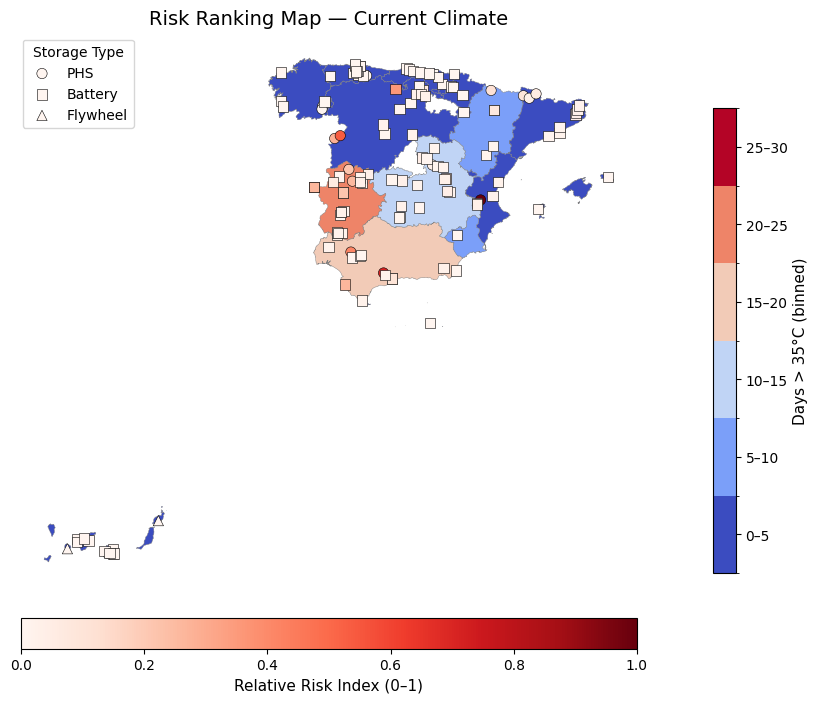

/tmp/ipython-input-3611229009.py:148: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_bg = cm.get_cmap("coolwarm", len(labels))


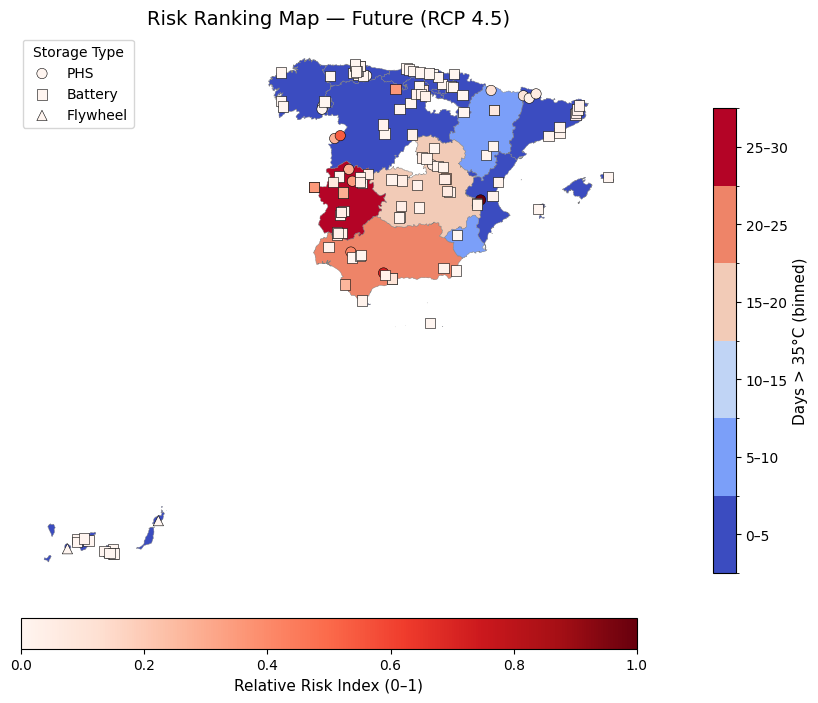

/tmp/ipython-input-3611229009.py:148: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_bg = cm.get_cmap("coolwarm", len(labels))


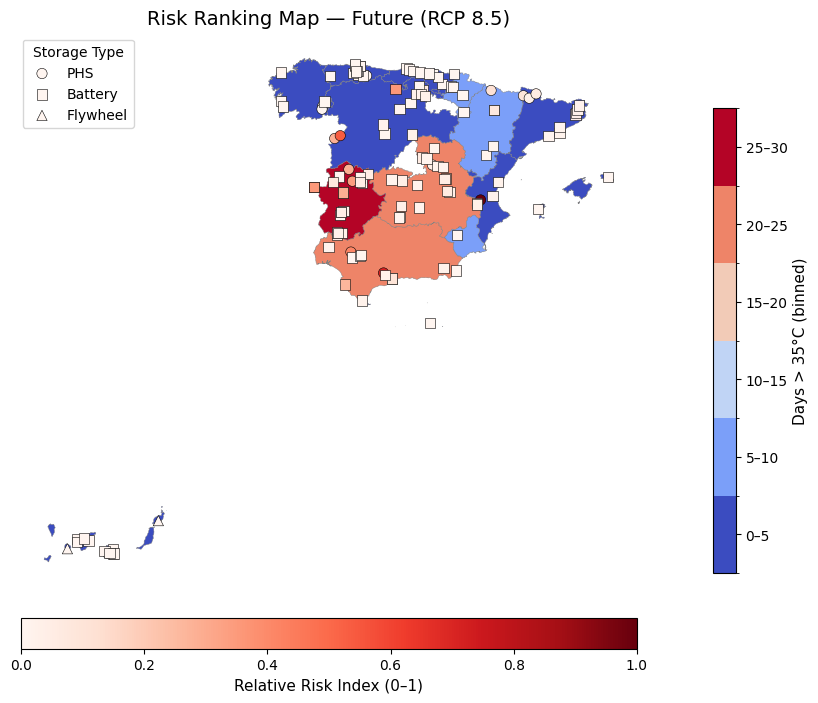

In [51]:
#THIS MAP WORKS - RELATIVE RISK (STEP 6)
# =========================================================
# CONFIG
# =========================================================
REGION_COL = "Region"
ASSET_TYPE_COL = "Storage type"
CAPACITY_COL = "Capacity (MWh)"
POWER_COL = "Power (MW)"
IMPORTANCE_COL = "Importance score"
VULN_COL = "Vulnerability hot days >35C"

HAZARDCURRENT_COL = "Hot days >35C 1991-2020 strength"
HAZARD45_COL     = "Hot days >35C 2011-2040 hazard strength RCP4.5"
HAZARD85_COL     = "Hot days >35C 2011-2040 hazard strength RCP8.5"

HOTDAYSCURRENT_COL = "Hot days >35C 1991-2020"
HOTDAYS45_COL      = "Hot days >35C 2011-2040 RCP4.5"
HOTDAYS85_COL      = "Hot days >35C 2011-2040 RCP8.5"


# =========================================================
# 1. Choose exposure measure (MWh > MW > count)
# =========================================================
def choose_exposure(row):
    if pd.notna(row.get(CAPACITY_COL)):
        return float(row[CAPACITY_COL])
    if pd.notna(row.get(POWER_COL)):
        return float(row[POWER_COL])
    return 1.0

data["Exposure"] = data.apply(choose_exposure, axis=1)


# =========================================================
# 2. Compute raw risk per asset (IPCC: hazard × vulnerability × exposure)
# =========================================================
data["Riskcurrent_raw"] = (
    data[HAZARDCURRENT_COL].astype(float) *
    data[VULN_COL].astype(float) *
    data["Exposure"].astype(float)
)

data["Risk45_raw"] = (
    data[HAZARD45_COL].astype(float) *
    data[VULN_COL].astype(float) *
    data["Exposure"].astype(float)
)

data["Risk85_raw"] = (
    data[HAZARD85_COL].astype(float) *
    data[VULN_COL].astype(float) *
    data["Exposure"].astype(float)
)


# =========================================================
# 3. Normalise asset-level risks (0–1)
# =========================================================
def normalize(s):
    vmin, vmax = s.min(), s.max()
    if vmax == vmin:
        return pd.Series(0, index=s.index)
    return (s - vmin) / (vmax - vmin)

data["Riskcurrent_norm"] = normalize(data["Riskcurrent_raw"])
data["Risk45_norm"]      = normalize(data["Risk45_raw"])
data["Risk85_norm"]      = normalize(data["Risk85_raw"])


# =========================================================
# 4. REGIONAL risk index (sum of asset risks per region)
# =========================================================
region_risk = (
    data.groupby(REGION_COL)[["Riskcurrent_raw", "Risk45_raw", "Risk85_raw"]]
    .sum()
    .reset_index()
)

region_risk["Riskcurrent_region_norm"] = normalize(region_risk["Riskcurrent_raw"])
region_risk["Risk45_region_norm"]      = normalize(region_risk["Risk45_raw"])
region_risk["Risk85_region_norm"]      = normalize(region_risk["Risk85_raw"])


# =========================================================
# 5. Create GeoDataFrame for assets
# =========================================================
points = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data["lon"], data["lat"]),
    crs="EPSG:4326"
)


# =========================================================
# 6. FIXED 5-DAY BINS FOR ALL HOT-DAYS COLUMNS (UNIFIED COLORBARS)
# =========================================================

hotday_cols = [
    HOTDAYSCURRENT_COL,
    HOTDAYS45_COL,
    HOTDAYS85_COL
]

bins = [0, 5, 10, 15, 20, 25, 30]
labels = ["0–5", "5–10", "10–15", "15–20", "20–25", "25–30"]

def apply_fixed_bins(df, col):
    df[col + "_binned"] = pd.cut(
        df[col],
        bins=bins,
        labels=labels,
        include_lowest=True,
        right=False
    )
    return df

for col in hotday_cols:
    data = apply_fixed_bins(data, col)


# =========================================================
# 7. MAP FUNCTION (consistent colorbars + separate point risk)
# =========================================================

def plot_risk_map(bg_col, point_col, title):

    fig, ax = plt.subplots(figsize=(10, 8))

    # Merge background values with region polygons
    background = regions.merge(
        data[[REGION_COL, bg_col + "_binned"]].drop_duplicates(subset=[REGION_COL]),
        left_on="NAME_1",
        right_on=REGION_COL,
        how="left"
    )

    # Background plot using binned hot days
    background.plot(
        column=bg_col + "_binned",
        cmap="coolwarm",
        linewidth=0.3,
        edgecolor="grey",
        ax=ax,
        legend=False
    )

    # --- Custom categorical colorbar (consistent across maps) ---
    cmap_bg = cm.get_cmap("coolwarm", len(labels))
    norm_bg = mcolors.BoundaryNorm(range(len(labels) + 1), cmap_bg.N)

    sm_bg = cm.ScalarMappable(cmap=cmap_bg, norm=norm_bg)
    sm_bg.set_array([])

    cbar1 = fig.colorbar(
        sm_bg, ax=ax, fraction=0.03, pad=0.02, shrink=0.8,
        ticks=np.arange(len(labels)) + 0.5
    )
    cbar1.set_ticklabels(labels)
    cbar1.set_label("Days > 35°C (binned)", fontsize=11)

    # --- Points (asset relative risk) ---
    vals = points[point_col].astype(float)
    norm = mcolors.Normalize(vmin=vals.min(), vmax=vals.max())

    markers = {"PHS": "o", "Battery": "s", "Flywheel": "^"}

    for stype, marker in markers.items():
        subset = points[points[ASSET_TYPE_COL] == stype]
        ax.scatter(
            subset.geometry.x,
            subset.geometry.y,
            c=subset[point_col],
            cmap="Reds",
            norm=norm,
            marker=marker,
            s=55,
            edgecolor="black",
            linewidth=0.4,
            zorder=5,
            label=stype
        )

    # Point colorbar
    sm_pts = cm.ScalarMappable(cmap="Reds", norm=norm)
    cbar2 = fig.colorbar(sm_pts, ax=ax, orientation="horizontal",
                         fraction=0.05, pad=0.05)
    cbar2.set_label("Relative Risk Index (0–1)", fontsize=11)

    # Layout
    plt.title(title, fontsize=14)
    plt.legend(title="Storage Type")
    plt.axis("off")
    plt.show()


# =========================================================
# 8. GENERATE MAPS
# =========================================================

# Current climate
plot_risk_map(
    bg_col=HOTDAYSCURRENT_COL,
    point_col="Riskcurrent_norm",
    title="Risk Ranking Map — Current Climate"
)

# RCP4.5
plot_risk_map(
    bg_col=HOTDAYS45_COL,
    point_col="Risk45_norm",
    title="Risk Ranking Map — Future (RCP 4.5)"
)

# RCP8.5
plot_risk_map(
    bg_col=HOTDAYS85_COL,
    point_col="Risk85_norm",
    title="Risk Ranking Map — Future (RCP 8.5)"
)


/tmp/ipython-input-957640248.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_bg = cm.get_cmap("coolwarm", len(labels))


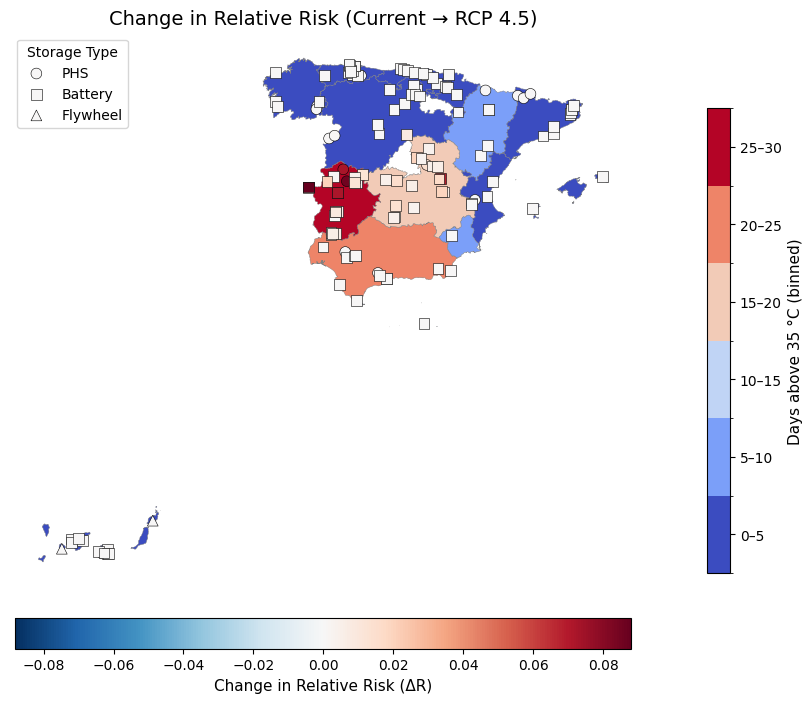

/tmp/ipython-input-957640248.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_bg = cm.get_cmap("coolwarm", len(labels))


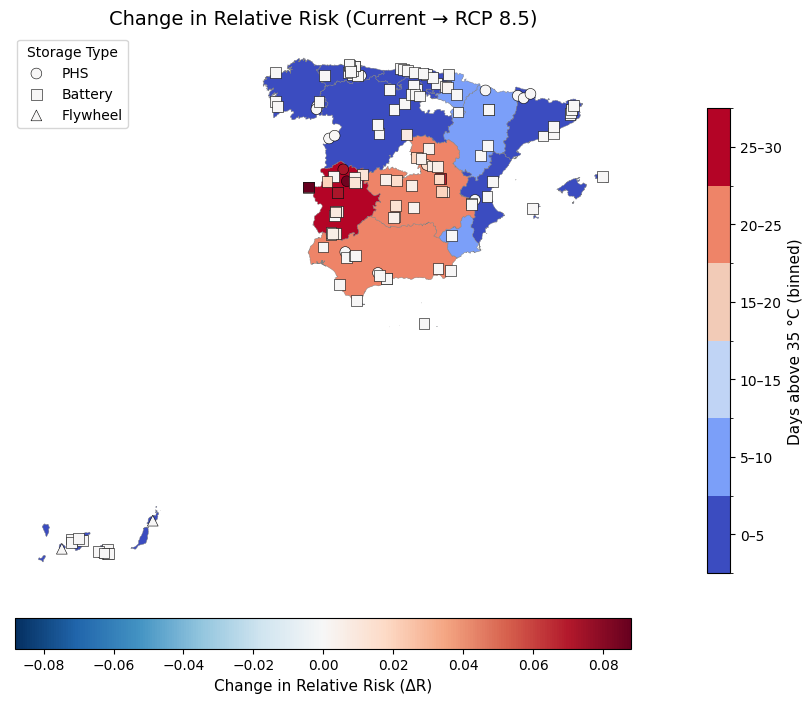

/tmp/ipython-input-957640248.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_bg = cm.get_cmap("coolwarm", len(labels))


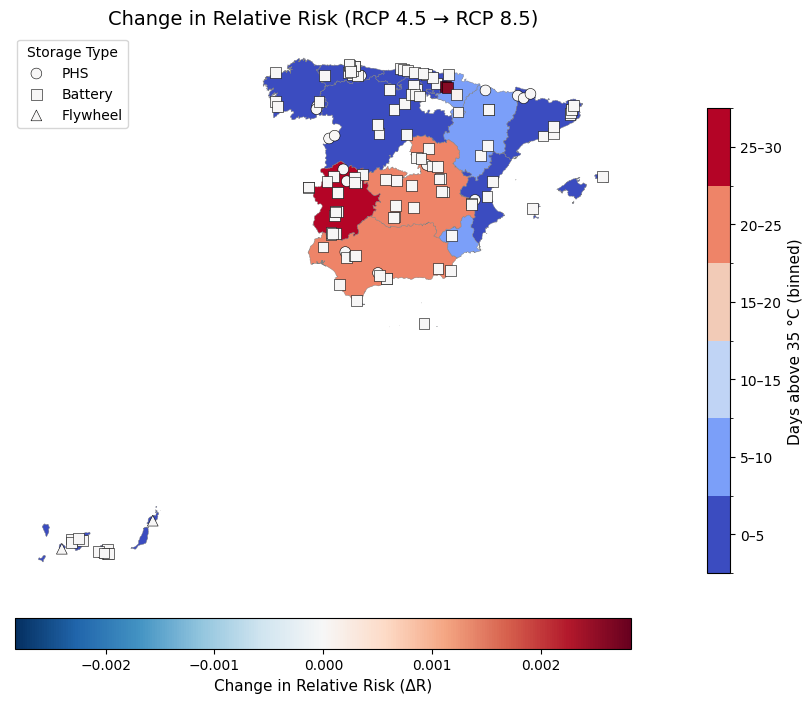

In [52]:
#CHANGES IN RELATIVE RISK
# =========================================================
# 1. COMPUTE DIFFERENCES BETWEEN SCENARIOS
# =========================================================

points["Delta_current_45"] = points["Risk45_norm"] - points["Riskcurrent_norm"]
points["Delta_current_85"] = points["Risk85_norm"] - points["Riskcurrent_norm"]
points["Delta_45_85"]      = points["Risk85_norm"] - points["Risk45_norm"]


# =========================================================
# 2. NEW PLOT FUNCTION FOR CHANGE MAPS (diverging colours)
# =========================================================

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def plot_change_map(bg_col, delta_col, title):
    fig, ax = plt.subplots(figsize=(10, 8))

    # Background layer (same hot-day bins)
    background = regions.merge(
        data[[REGION_COL, bg_col + "_binned"]].drop_duplicates(subset=[REGION_COL]),
        left_on="NAME_1", right_on=REGION_COL, how="left"
    )

    background.plot(
        column=bg_col + "_binned",
        cmap="coolwarm",
        linewidth=0.3,
        edgecolor="grey",
        ax=ax,
        legend=False
    )

    # Background colorbar (same bins for all maps)
    labels = ["0–5","5–10","10–15","15–20","20–25","25–30"]
    cmap_bg = cm.get_cmap("coolwarm", len(labels))
    norm_bg = mcolors.BoundaryNorm(range(len(labels)+1), cmap_bg.N)

    sm_bg = cm.ScalarMappable(cmap=cmap_bg, norm=norm_bg)
    sm_bg.set_array([])

    cbar1 = fig.colorbar(
        sm_bg, ax=ax, fraction=0.03, pad=0.02, shrink=0.8,
        ticks=np.arange(len(labels)) + 0.5
    )
    cbar1.set_ticklabels(labels)
    cbar1.set_label("Days above 35 °C (binned)", fontsize=11)

    # ---------------------------------------
    # POINTS (risk change: diverging colormap)
    vals = points[delta_col].astype(float)
    absmax = max(abs(vals.min()), abs(vals.max()))
    norm = mcolors.TwoSlopeNorm(vcenter=0, vmin=-absmax, vmax=absmax)

    for stype, marker in {"PHS":"o","Battery":"s","Flywheel":"^"}.items():
        subset = points[points[ASSET_TYPE_COL] == stype]

        ax.scatter(
            subset.geometry.x,
            subset.geometry.y,
            c=subset[delta_col],
            cmap="RdBu_r",
            norm=norm,
            marker=marker,
            s=60,
            edgecolor="black",
            linewidth=0.4,
            zorder=5,
            label=stype
        )

    # Point colorbar (risk change)
    sm_pts = cm.ScalarMappable(cmap="RdBu_r", norm=norm)
    cbar2 = fig.colorbar(
        sm_pts, ax=ax, orientation="horizontal",
        fraction=0.05, pad=0.05
    )
    cbar2.set_label("Change in Relative Risk (ΔR)", fontsize=11)

    plt.title(title, fontsize=14)
    plt.legend(title="Storage Type")
    plt.axis("off")
    plt.show()


# =========================================================
# 3. PLOT CHANGE MAPS
# =========================================================

# Current → RCP4.5
plot_change_map(
    bg_col=HOTDAYS45_COL,
    delta_col="Delta_current_45",
    title="Change in Relative Risk (Current → RCP 4.5)"
)

# Current → RCP8.5
plot_change_map(
    bg_col=HOTDAYS85_COL,
    delta_col="Delta_current_85",
    title="Change in Relative Risk (Current → RCP 8.5)"
)

# RCP4.5 → RCP8.5
plot_change_map(
    bg_col=HOTDAYS85_COL,
    delta_col="Delta_45_85",
    title="Change in Relative Risk (RCP 4.5 → RCP 8.5)"
)


/tmp/ipython-input-377760511.py:117: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_bg = cm.get_cmap("coolwarm", len(categories))


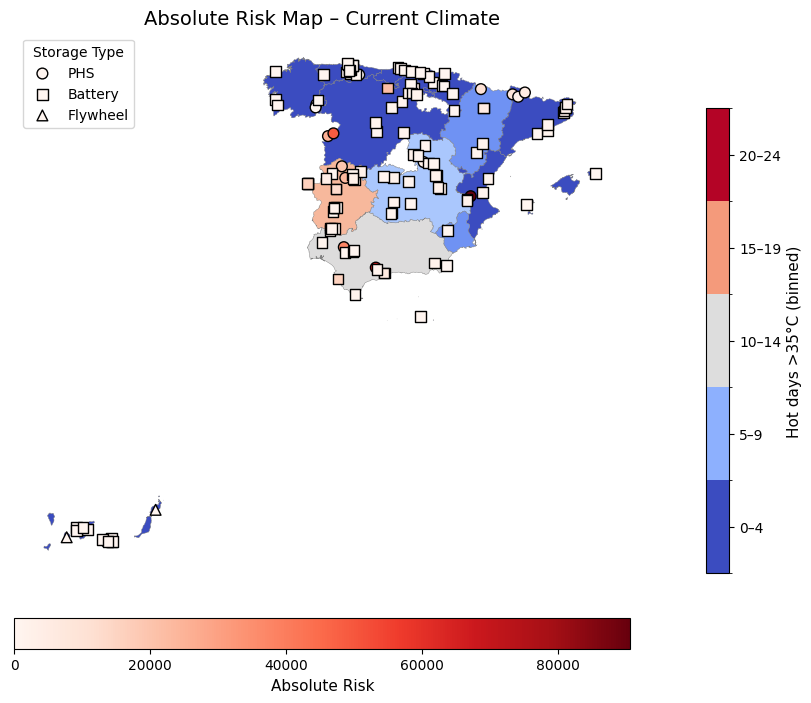

/tmp/ipython-input-377760511.py:117: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_bg = cm.get_cmap("coolwarm", len(categories))


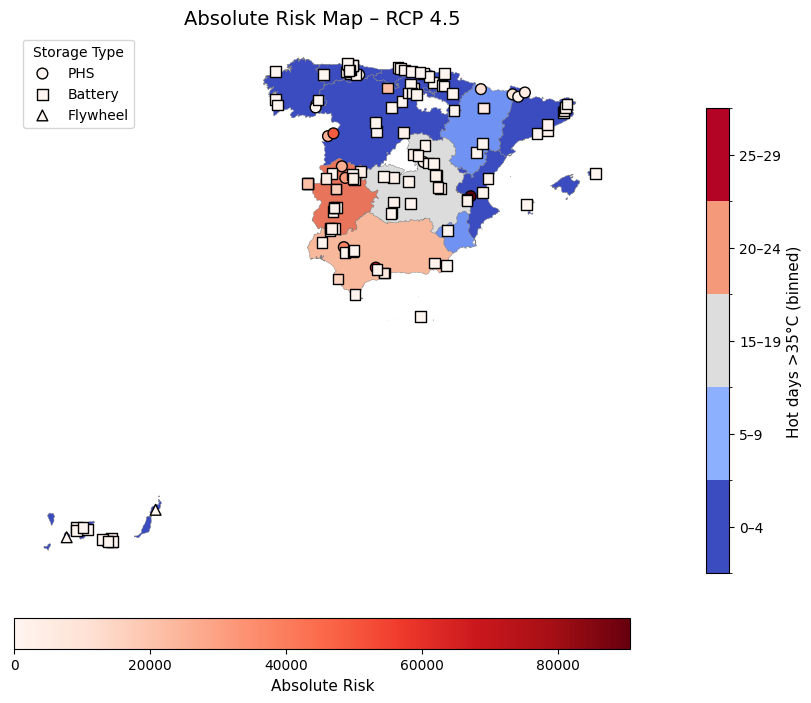

/tmp/ipython-input-377760511.py:117: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_bg = cm.get_cmap("coolwarm", len(categories))


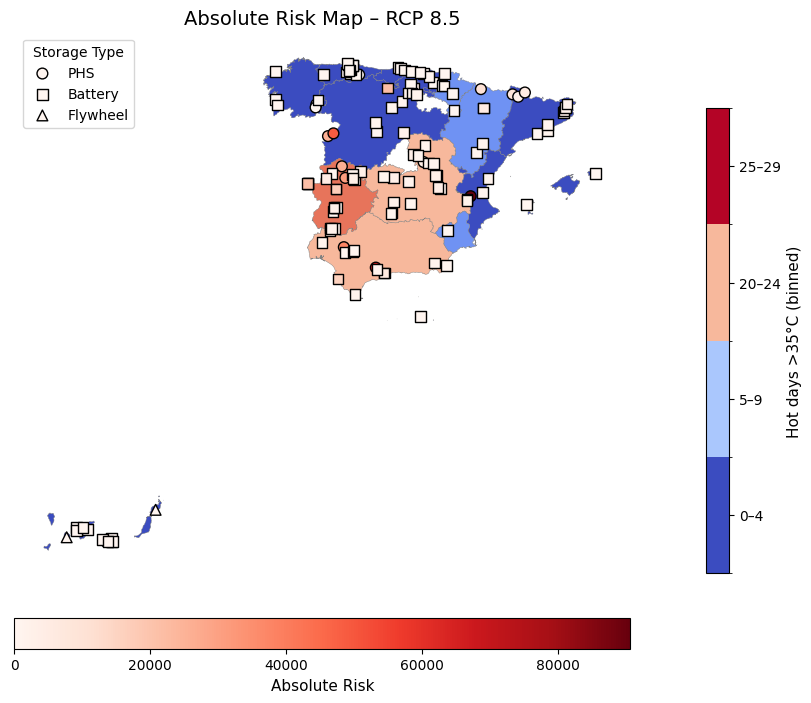

/tmp/ipython-input-377760511.py:117: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_bg = cm.get_cmap("coolwarm", len(categories))


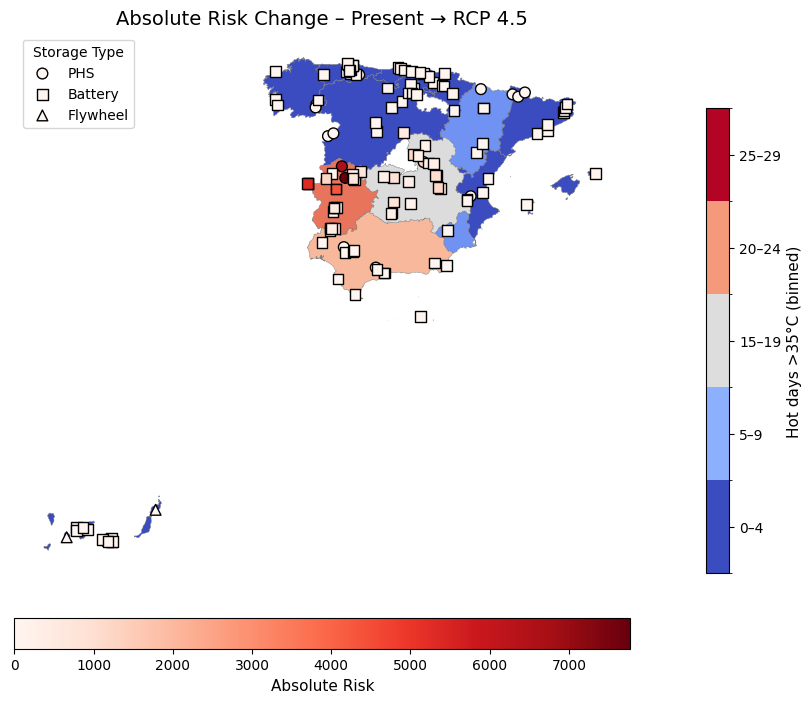

/tmp/ipython-input-377760511.py:117: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_bg = cm.get_cmap("coolwarm", len(categories))


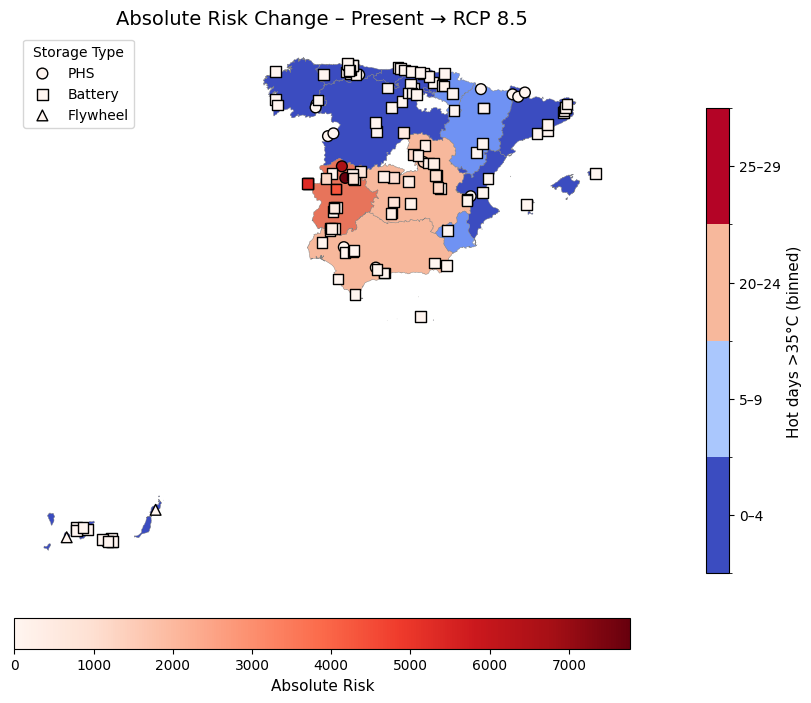

In [53]:
#ABSOLUTE RISK MAPS
# ============================================
# CONFIG
# ============================================
REGION_COL = "Region"
TYPE_COL = "Storage type"
CAPACITY_COL = "Capacity (MWh)"
POWER_COL = "Power (MW)"
IMPORTANCE_COL = "Importance score"
VULN_COL = "Vulnerability hot days >35C"

HAZ_CUR = "Hot days >35C 1991-2020 strength"
HAZ_45 = "Hot days >35C 2011-2040 hazard strength RCP4.5"
HAZ_85 = "Hot days >35C 2011-2040 hazard strength RCP8.5"

HOT_CUR = "Hot days >35C 1991-2020"
HOT_45 = "Hot days >35C 2011-2040 RCP4.5"
HOT_85 = "Hot days >35C 2011-2040 RCP8.5"

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# ============================================
# 1. EXPOSURE SELECTION (MWh > MW > 1)
# ============================================
def choose_exposure(row):
    if pd.notna(row.get(CAPACITY_COL)):
        return float(row[CAPACITY_COL])
    if pd.notna(row.get(POWER_COL)):
        return float(row[POWER_COL])
    return 1.0

data["Exposure"] = data.apply(choose_exposure, axis=1)

# ============================================
# 2. ABSOLUTE RISK CALCULATION
# ============================================
# Risk = Hazard × Vulnerability × Exposure × Importance

data["Risk_current_abs"] = (
    data[HAZ_CUR].astype(float)
    * data[VULN_COL].astype(float)
    * data["Exposure"].astype(float)
    * data[IMPORTANCE_COL].astype(float)
)

data["Risk_45_abs"] = (
    data[HAZ_45].astype(float)
    * data[VULN_COL].astype(float)
    * data["Exposure"].astype(float)
    * data[IMPORTANCE_COL].astype(float)
)

data["Risk_85_abs"] = (
    data[HAZ_85].astype(float)
    * data[VULN_COL].astype(float)
    * data["Exposure"].astype(float)
    * data[IMPORTANCE_COL].astype(float)
)

# ============================================
# 3. ABSOLUTE RISK CHANGE
# ============================================
data["Risk_change_45"] = data["Risk_45_abs"] - data["Risk_current_abs"]
data["Risk_change_85"] = data["Risk_85_abs"] - data["Risk_current_abs"]

# ============================================
# 4. Create GeoDataFrame for POINTS
# ============================================
points = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data["lon"], data["lat"]),
    crs="EPSG:4326"
)

# ============================================
# 5. BINNING HOT DAYS (for consistent background)
# ============================================
def bin_hot_days(df, col):
    bins = [0, 5, 10, 15, 20, 25, 30, np.inf]
    labels = ["0–4", "5–9", "10–14", "15–19", "20–24", "25–29", "30+"]
    df[col + "_binned"] = pd.cut(df[col], bins=bins, labels=labels, right=False)
    return df

for col in [HOT_CUR, HOT_45, HOT_85]:
    data = bin_hot_days(data, col)

# ============================================
# 6. PLOTTING FUNCTION FOR ABSOLUTE RISK MAPS
# ============================================
def plot_absolute_risk(bg_col, risk_col, title):
    fig, ax = plt.subplots(figsize=(10, 8))

    # ---- Background map using HOT-DAY bins ----
    merged_bg = regions.merge(
        data[[REGION_COL, bg_col + "_binned"]].drop_duplicates(subset=[REGION_COL]),
        left_on="NAME_1",
        right_on=REGION_COL,
        how="left"
    )

    merged_bg.plot(
        column=bg_col + "_binned",
        cmap="coolwarm",
        ax=ax,
        edgecolor="grey",
        linewidth=0.3,
        legend=False
    )

    # Custom legend for background bins
    categories = merged_bg[bg_col + "_binned"].dropna().unique().tolist()
    categories.sort(key=lambda c: float(c.split("–")[0]) if "–" in c else 99)
    cmap_bg = cm.get_cmap("coolwarm", len(categories))
    sm_bg = cm.ScalarMappable(
        cmap=cmap_bg,
        norm=mcolors.BoundaryNorm(range(len(categories)+1), cmap_bg.N)
    )
    cbar1 = fig.colorbar(sm_bg, ax=ax, fraction=0.03, pad=0.02, shrink=0.8)
    cbar1.set_ticks(np.arange(len(categories)) + 0.5)
    cbar1.set_ticklabels(categories)
    cbar1.set_label("Hot days >35°C (binned)", fontsize=11)

    # ---- Storage projects (absolute risk) ----
    vals = points[risk_col].astype(float)
    norm = mcolors.Normalize(vmin=vals.min(), vmax=vals.max())

    markers = {"PHS": "o", "Battery": "s", "Flywheel": "^"}

    for t, marker in markers.items():
        subset = points[points[TYPE_COL] == t]
        ax.scatter(
            subset.geometry.x,
            subset.geometry.y,
            c=subset[risk_col],
            cmap="Reds",
            norm=norm,
            marker=marker,
            s=60,
            edgecolor="black",
            zorder=5,
            label=t
        )

    sm_risk = cm.ScalarMappable(norm=norm, cmap="Reds")
    cbar2 = fig.colorbar(
        sm_risk, ax=ax, orientation="horizontal",
        fraction=0.05, pad=0.07
    )
    cbar2.set_label("Absolute Risk", fontsize=11)

    plt.title(title, fontsize=14)
    plt.legend(title="Storage Type")
    plt.axis("off")
    plt.show()


# ============================================
# 7. PLOT ABSOLUTE RISK MAPS
# ============================================

# ---- CURRENT ----
plot_absolute_risk(
    bg_col=HOT_CUR,
    risk_col="Risk_current_abs",
    title="Absolute Risk Map – Current Climate"
)

# ---- RCP 4.5 ----
plot_absolute_risk(
    bg_col=HOT_45,
    risk_col="Risk_45_abs",
    title="Absolute Risk Map – RCP 4.5"
)

# ---- RCP 8.5 ----
plot_absolute_risk(
    bg_col=HOT_85,
    risk_col="Risk_85_abs",
    title="Absolute Risk Map – RCP 8.5"
)

# ============================================
# 8. MAP RISK CHANGES
# ============================================

# ---- Change Present → RCP 4.5 ----
plot_absolute_risk(
    bg_col=HOT_45,
    risk_col="Risk_change_45",
    title="Absolute Risk Change – Present → RCP 4.5"
)

# ---- Change Present → RCP 8.5 ----
plot_absolute_risk(
    bg_col=HOT_85,
    risk_col="Risk_change_85",
    title="Absolute Risk Change – Present → RCP 8.5"
)


In [ ]:
data.loc[data['Region']=="CastillayLeón",
         ['Storage type','Power (MW)', 'Capacity (MWh)',
          'M_asset_current_norm','M_asset_future45_norm']]

,Storage type,Power (MW),Capacity (MWh),M_asset_current_norm,M_asset_future45_norm
67,Battery,66.00,198.0,0.013080,0.013098
104,PHS,432.00,4285.0,0.283443,0.283456
105,PHS,858.00,8100.0,0.535812,0.535821
106,Battery,13.00,26.0,0.001702,0.001720
107,Battery,75.00,150.0,0.009905,0.009923
108,Battery,27.46,59.9,0.003945,0.003962
109,Battery,360.80,3610.0,0.238791,0.238804
110,Battery,30.00,60.0,0.003951,0.003969
111,Battery,195.00,780.0,0.051581,0.051598
112,Battery,0.60,3.0,0.000181,0.000198
